# Transfer Learning Lab

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

import tensorflow as tf
from keras import layers


## Load Data

In [2]:
batch_size = 32

In [3]:

train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

## Training Dataset

In [16]:
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    batch_size=batch_size,
    seed=123)


Found 276 files belonging to 2 classes.
Using 221 files for training.


In [15]:
train_ds_10

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Validation Dataset

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,)

Found 649 files belonging to 2 classes.
Using 129 files for validation.


In [7]:
class_names = train_ds_10.class_names
print(class_names)

['benign', 'malignant']


## Visualize the Data
The first nine images from the training set.

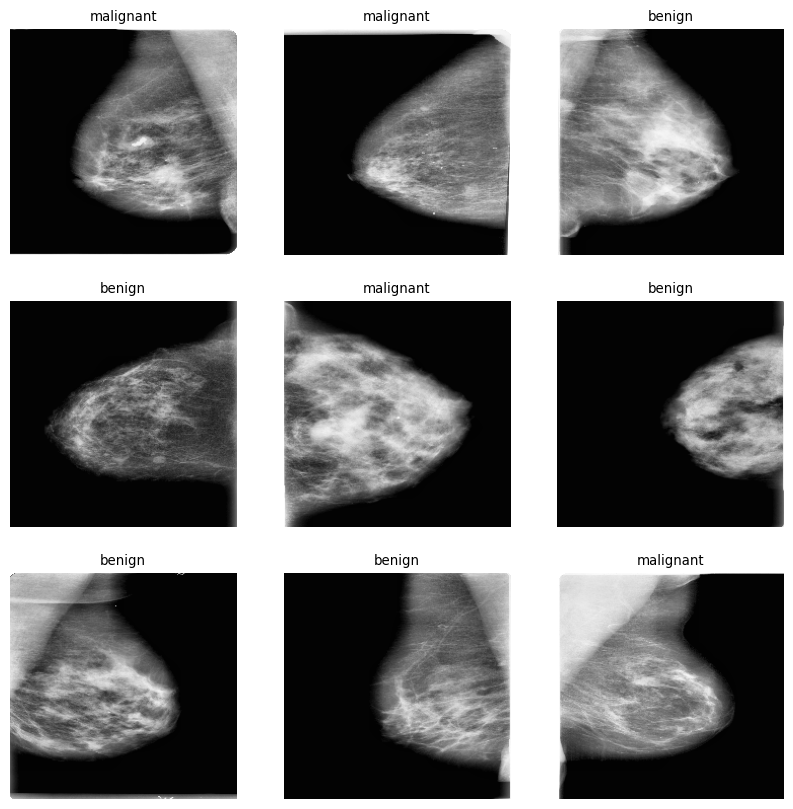

In [8]:
_ = plt.figure(figsize=(10, 10))
for images, labels in train_ds_10.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    _ = plt.imshow(images[i].numpy().astype("uint8"))
    _ = plt.title(class_names[labels[i]])
    _ = plt.axis("off")

## Augmentation Model

In [9]:
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    ], name ="data_augmentation")


## Build the Model

In [10]:
input_shape = (224,224,3)
# base_model = keras.applications.resnet_v2.ResNet152V2(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224,224,3),
#     classes=1000,
#     classifier_activation='softmax',
# )
# base_model.trainable = False

In [11]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

## Define Inputs

In [12]:
# Create the input
inputs = tf.keras.Input(shape=input_shape, batch_size=None, name="input_layer")
# Perform resnet specific preprocessing
# x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
# Add augmentation model as a layer
x = augmentation(inputs)
# Give base model inputs (after augmentation) in inference model 
x = base_model(x, training=False)
# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# Add output layer 
outputs = layers.Dense(units=1, activation='sigmoid', name='output_layer')(x)
# Create the model with inputs and outputs
model_1 = keras.Model(inputs, outputs)
# Compile the Model
model_1.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])
# Fit the model
model_1_history = model_1.fit(train_ds_10, epochs=5, validation_data=val_ds)


Epoch 1/5
7/7 [==============================] - 28s 2s/step - loss: 0.6939 - accuracy: 0.5113 - val_loss: 0.6968 - val_accuracy: 0.5891
Epoch 2/5
7/7 [==============================] - 17s 2s/step - loss: 0.6890 - accuracy: 0.5882 - val_loss: 0.6917 - val_accuracy: 0.5891
Epoch 3/5
7/7 [==============================] - 18s 2s/step - loss: 0.6784 - accuracy: 0.5611 - val_loss: 0.6894 - val_accuracy: 0.5581
Epoch 4/5
7/7 [==============================] - 17s 2s/step - loss: 0.6446 - accuracy: 0.6244 - val_loss: 0.6808 - val_accuracy: 0.5736
Epoch 5/5
7/7 [==============================] - 17s 2s/step - loss: 0.6722 - accuracy: 0.6018 - val_loss: 0.6785 - val_accuracy: 0.5814


In [13]:
# Model summary, note trainable weights
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                             